In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

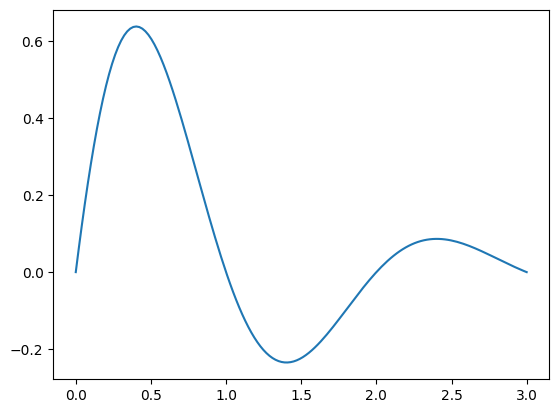

In [2]:
# Input data
X = np.expand_dims(np.linspace(0, 3, 150), -1)
T = np.expand_dims(np.linspace(0, 3, 150), -1)
U = np.sin(np.pi*X) * np.exp(-T)

x = torch.tensor(X, requires_grad=True)
t = torch.tensor(T, requires_grad=True)
u = torch.tensor(U)

plt.plot(X,U)

In [3]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        self.layers = nn.Sequential(nn.Linear(2,12),
                                    nn.Tanh(),
                                    nn.Linear(12,12),
                                    nn.Tanh(),
                                    nn.Linear(12,1))

    def forward(self, x):
        return self.layers(x)

pinn = model()

In [4]:
# Physics loss
def pde_loss(u, t, x):
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
    f = u_t - 0.01*u_xx
    
    return torch.mean(f**2)

# Data loss
def data_loss(u_pred, u):
    return torch.mean((u_pred - u)**2)

In [5]:
opt = Adam(pinn.parameters(), lr=.01)

for i in range(1000):
    # Forward pass
    u_pred = pinn(torch.cat([x.float(), t.float()], dim=1))
    
    # Losses
    pl = pde_loss(u_pred, x, t)
    dl = data_loss(u_pred, u)
    loss = pl + dl
    
    # Update
    opt.zero_grad()
    loss.backward()
    opt.step()

In [6]:
X = np.expand_dims(np.linspace(0, 7, 300), -1)
T = np.expand_dims(np.linspace(0, 7, 300), -1)
U = np.sin(np.pi*X) * np.exp(-T)

x = torch.tensor(X, requires_grad=True)
t = torch.tensor(T, requires_grad=True)
u = torch.tensor(U)

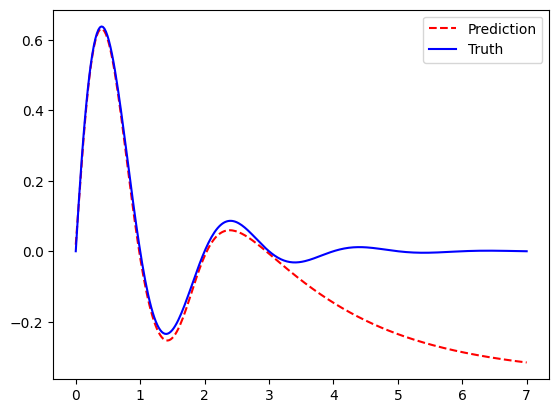

In [7]:
# Prediction
u_pred = pinn(torch.cat([x.float(), t.float()], dim=1))

# Plot    
plt.plot(X, u_pred.detach(), 'r--', label='Prediction')
plt.plot(X, U, 'b-', label='Truth')
plt.legend();